# Example 4: Multiple runs as validation

Here we explore running `pyvbmc` multiple times in order to validate the results: if the final variational posteriors obtained from several different initial points are consistent, we can be more confident that the results are correct.

This notebook is Part 4 of a series of notebooks in which we present various example usages for VBMC with the `pyvbmc` package.

In [1]:
import numpy as np
import scipy.stats as scs
from scipy.optimize import minimize
from pyvbmc.vbmc import VBMC
import matplotlib.pyplot as plt
import dill

## 1. Model definition

We use the same toy target function as in Example 1, a broad [Rosenbrock's banana function](https://en.wikipedia.org/wiki/Rosenbrock_function) in $D = 2$, with unbounded parameters:

In [2]:
D = 2  # We'll use a 2-D problem for a quicker demonstration
prior_mu = np.zeros(D)
prior_var = 3 * np.ones(D)


def log_prior(theta):
    """Multivariate normal prior on theta."""
    cov = np.diag(prior_var)
    return scs.multivariate_normal(prior_mu, cov).logpdf(theta)


# log-likelihood (Rosenbrock)
def log_likelihood(theta):
    """D-dimensional Rosenbrock's banana function."""
    theta = np.atleast_2d(theta)

    x, y = theta[:, :-1], theta[:, 1:]
    return -np.sum((x**2 - y) ** 2 + (x - 1) ** 2 / 100, axis=1)


# Full model:
def log_joint(theta, data=np.ones(D)):
    return log_likelihood(theta) + log_prior(theta)


LB = np.full((1, D), -np.inf)  # Lower bounds
UB = np.full((1, D), np.inf)  # Upper bounds
PLB = np.full((1, D), prior_mu - np.sqrt(prior_var))  # Plausible lower bounds
PUB = np.full((1, D), prior_mu + np.sqrt(prior_var))  # Plausible upper bounds
options = {
    "max_fun_evals": 50 * D  # Slightly reduced from 50 * (D + 2), for speed
}

## 2. Validation
For validation, we recommend running `pyvbmc` 3-4 times from different initial points:

In [3]:
np.random.seed(42)
n_runs = 3
vps, elbos, elbo_sds, success_flags, result_dicts = [], [], [], [], []
for i in range(n_runs):
    print(f"PyVBMC run {i} of {n_runs}")

    # Determine initial point x0:
    if i == 0:
        x0 = prior_mu  # First run, start from prior mean
    else:
        x0 = np.random.uniform(PLB, PUB)  # Other runs, randomize
    # Preliminary maximum a posteriori (MAP) estimation:
    x0 = minimize(lambda t: -log_joint(t), x0).x

    # Run pyvbmc:
    vbmc = VBMC(
        log_joint,
        x0,
        LB,
        UB,
        PLB,
        PUB,
        user_options=options,
    )
    vp, elbo, elbo_sd, success_flag, result_dict = vbmc.optimize()

    # Record the results:
    vps.append(vp)
    elbos.append(elbo)
    elbo_sds.append(elbo_sd)
    success_flags.append(success_flag)
    result_dicts.append(result_dict)

PyVBMC run 0 of 3
Reshaping x0 to row vector.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10          -1.79         1.06     57003.35        2        inf     start warm-up
     1         15          -1.84         0.06         0.65        2        inf     
     2         20          -1.81         0.00         0.09        2       2.33     
     3         25          -1.81         0.00         0.00        2     0.0355     
     4         30          -1.84         0.00         0.00        2      0.158     end warm-up
     5         35          -1.81         0.00         0.00        2      0.189     
     6         40          -1.81         0.00         0.01        2      0.158     
     7         45          -1.69         0.00         0.04        5       1.24     
     8         50          -1.64         0.00         0.04        6       1.18     roto

/tmp/ipykernel_30802/114186639.py:13: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  x0 = minimize(lambda t: -log_joint(t), x0).x


     0         10          -1.48         0.84    180274.28        2        inf     start warm-up
     1         15          -1.80         0.07         3.68        2        inf     
     2         20          -1.82         0.00         0.02        2      0.524     
     3         25          -1.80         0.00         0.00        2     0.0838     
     4         30          -1.80         0.00         0.00        2     0.0287     end warm-up
     5         35          -1.79         0.00         0.00        2     0.0543     
     6         40          -1.82         0.00         0.00        2      0.114     
     7         45          -1.68         0.00         0.03        5       1.05     
     8         50          -1.62         0.00         0.02        6      0.762     rotoscale, undo rotoscale
     9         55          -1.59         0.00         0.01        9       0.25     
    10         60          -1.58         0.00         0.01       11      0.178     
    11         65          

We now perform some diagnostic checks on the variational solution. First, we check that the ELBO's from different runs are close to each other (i.e. with a difference much smaller than 1):

In [4]:
print(elbos)

[-1.5302647634435038, -1.5325138484850769, -1.5327194189639894]


Then, we check that the variational posteriors from distinct runs are similar. As a measure of similarity, we compute the Kullback-Leibler divergence between each pair:

In [5]:
kl_matrix = np.zeros((n_runs, n_runs))
for i in range(n_runs):
    for j in range(i, n_runs):
        # The `kldiv` method computes the divergence in both directions:
        kl_ij, kl_ji = vps[i].kl_div(vp2=vps[j])
        kl_matrix[i, j] = kl_ij
        kl_matrix[j, i] = kl_ji

Note that the KL divergence is asymmetric, so we have an asymmetric matrix:

In [6]:
print(kl_matrix)

[[-0.          0.0079975   0.0042432 ]
 [ 0.00863534 -0.          0.01145025]
 [ 0.00418927  0.01150484 -0.        ]]


Ideally, we want all KL divergence matrix entries to be much smaller than 1. For a qualitative validation, we recommend a visual inspection of the posteriors:

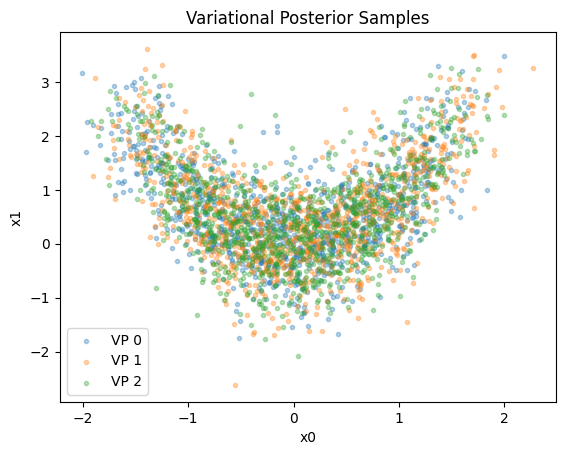

In [7]:
for i, vp in enumerate(vps):
    samples, __ = vp.sample(1000)
    plt.scatter(
        samples[:, 0],
        samples[:, 1],
        alpha=1 / len(vps),
        marker=".",
        label=f"VP {i}",
    )
plt.title("""Variational Posterior Samples""")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend();

We can also check that convergence was acheived in all runs, according to `pyvbmc` (we want `success_flag = True` for each run):

In [8]:
print(success_flags)

[True, True, True]


Finally, we can pick the variational solution with highest ELCBO (the lower confidence bound on the ELBO).

In [9]:
beta_lcb = 3.0  # Standard confidence parameter (in standard deviations)
# beta_lcb = 5.0  # This is more conservative
elcbos = np.array(elbos) - beta_lcb * np.array(elbo_sds)
idx_best = np.argmax(elcbos)
print(idx_best)

0


We'll save this best posterior to a file, so we can compare it against our results in the next notebook:

In [10]:
with open("noise_free_vp.pkl", "wb") as f:
    dill.dump(vps[idx_best], f)

## 3. Conclusions

In this notebook, we have shown you some techniques to validate the results of `pyvbmc` by comparing statitics across multiple runs.

In the next notebook, we will demonstrate using `pyvbmc` with models in which the likelihood function is noisy, or can only be estimated up to some noise.

## Example 4: full code

The following cell includes in a single place all the code used in Example 4, without the extra fluff.

In [11]:
assert False  # skip this cell

import numpy as np
import scipy.stats as scs
from scipy.optimize import minimize
from pyvbmc.vbmc import VBMC
import matplotlib.pyplot as plt
import dill


D = 2  # We'll use a 2-D problem for a quicker demonstration
prior_mu = np.zeros(D)
prior_var = 3 * np.ones(D)


def log_prior(theta):
    """Multivariate normal prior on theta."""
    cov = np.diag(prior_var)
    return scs.multivariate_normal(prior_mu, cov).logpdf(theta)


# log-likelihood (Rosenbrock)
def log_likelihood(theta):
    """D-dimensional Rosenbrock's banana function."""
    theta = np.atleast_2d(theta)

    x, y = theta[:, :-1], theta[:, 1:]
    return -np.sum((x**2 - y) ** 2 + (x - 1) ** 2 / 100, axis=1)


# Full model:
def log_joint(theta, data=np.ones(D)):
    return log_likelihood(theta) + log_prior(theta)


LB = np.full((1, D), -np.inf)  # Lower bounds
UB = np.full((1, D), np.inf)  # Upper bounds
PLB = np.full((1, D), prior_mu - np.sqrt(prior_var))  # Plausible lower bounds
PUB = np.full((1, D), prior_mu + np.sqrt(prior_var))  # Plausible upper bounds
options = {
    "max_fun_evals": 50 * D  # Slightly reduced from 50 * (D + 2), for speed
}


np.random.seed(42)
n_runs = 3
vps, elbos, elbo_sds, success_flags, result_dicts = [], [], [], [], []
for i in range(n_runs):
    print(f"PyVBMC run {i} of {n_runs}")

    # Determine initial point x0:
    if i == 0:
        x0 = prior_mu  # First run, start from prior mean
    else:
        x0 = np.random.uniform(PLB, PUB)  # Other runs, randomize
    # Preliminary maximum a posteriori (MAP) estimation:
    x0 = minimize(lambda t: -log_joint(t), x0).x

    # Run pyvbmc:
    vbmc = VBMC(
        log_joint,
        x0,
        LB,
        UB,
        PLB,
        PUB,
        user_options=options,
    )
    vp, elbo, elbo_sd, success_flag, result_dict = vbmc.optimize()

    # Record the results:
    vps.append(vp)
    elbos.append(elbo)
    elbo_sds.append(elbo_sd)
    success_flags.append(success_flag)
    result_dicts.append(result_dict)


print(elbos)


kl_matrix = np.zeros((n_runs, n_runs))
for i in range(n_runs):
    for j in range(i, n_runs):
        # The `kldiv` method computes the divergence in both directions:
        kl_ij, kl_ji = vps[i].kl_div(vp2=vps[j])
        kl_matrix[i, j] = kl_ij
        kl_matrix[j, i] = kl_ji


print(kl_matrix)


for i, vp in enumerate(vps):
    samples, __ = vp.sample(1000)
    plt.scatter(
        samples[:, 0],
        samples[:, 1],
        alpha=1 / len(vps),
        marker=".",
        label=f"VP {i}",
    )
plt.title("""Variational Posterior Samples""")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()


print(success_flags)


beta_lcb = 3.0  # Standard confidence parameter (in standard deviations)
# beta_lcb = 5.0  # This is more conservative
elcbos = np.array(elbos) - beta_lcb * np.array(elbo_sds)
idx_best = np.argmax(elcbos)
print(idx_best)


with open("noise_free_vp.pkl", "wb") as f:
    dill.dump(vps[idx_best], f)

AssertionError: 

## Acknowledgments

Work on the `pyvbmc` package was funded by the [Finnish Center for Artificial Intelligence FCAI](https://fcai.fi/).